<a href="https://colab.research.google.com/github/elbixos/M2_Connectionnisme/blob/master/DeepMim/Cours/DeepMim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Commencons par charger nos données

In [4]:

import pandas as pd
from tensorflow import keras

dataset_path = keras.utils.get_file("evalMim.csv", "https://raw.githubusercontent.com/elbixos/M2_Connectionnisme/master/DeepMim/Sources/evalMim.csv")


column_names = ['line1','line2','line3','line4','eval']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()


,line1,line2,line3,line4,eval
138,7,5,1,1,1
139,7,5,2,0,-1
140,7,5,2,1,1
141,7,5,3,0,1
142,7,5,3,1,-1


Puis, on sépare le label (eval) des caractéristiques

In [6]:


train_labels = dataset.pop('eval')
dataset.tail()


,line1,line2,line3,line4
138,7,5,1,1
139,7,5,2,0
140,7,5,2,1
141,7,5,3,0
142,7,5,3,1


On peut aussi voir les labels

In [30]:
print(dataset.shape)

(143, 4)


In [0]:

train_labels.tail()


138    1
139   -1
140    1
141    1
142   -1
Name: eval, dtype: int64

On peut maintenant construire le modele

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import tensorflow as tf

from tensorflow.keras import layers

def build_model():
  model = keras.Sequential([
    layers.Dense(32, activation='relu',input_shape=(4,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()


Et regarder sa tete...

In [78]:
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_19 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


Essayons quelques prédictions

In [79]:
example_batch = dataset[:5]
example_batch

,line1,line2,line3,line4
0,0,0,0,0
1,1,0,0,0
2,1,1,0,0
3,2,0,0,0
4,2,1,0,0


In [80]:
example_result = model.predict(example_batch)
example_result

array([[ 0.        ],
       [-0.01288006],
       [ 0.05661705],
       [-0.02576013],
       [-0.02150056]], dtype=float32)

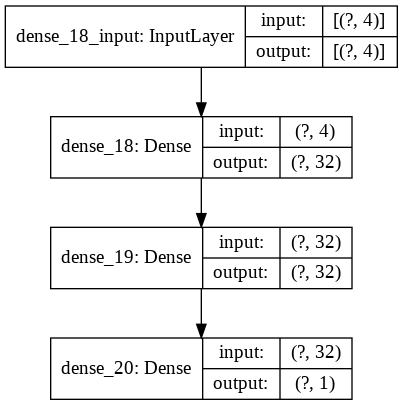

In [81]:
keras.utils.plot_model(model, 'my_first_model_with_shape_info.png', show_shapes=True)


Commencons l'entrainement

In [82]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Voyons ce qui s'est passé

In [83]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,0.338710,0.458181,0.338710,0.833288,0.757428,0.833288,995
996,0.362128,0.475252,0.362128,0.991721,0.833124,0.991721,996
997,0.374348,0.488712,0.374348,0.820833,0.731367,0.820833,997
998,0.353536,0.466885,0.353536,0.855098,0.720792,0.855098,998
999,0.352129,0.467822,0.352129,0.887002,0.769217,0.887002,999


Avec une courbe

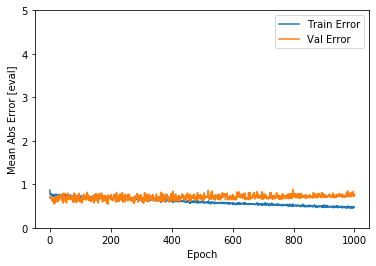

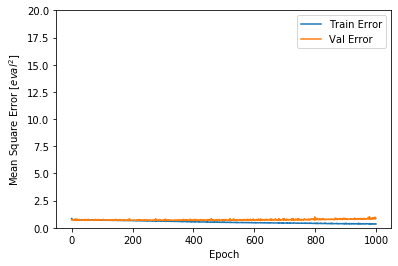

In [84]:
import matplotlib.pyplot as plt


def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [eval]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$eval^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


Revoyons ce qui se passe maintenant en prédiction

In [86]:
example_batch = dataset[:5]
example_result = model.predict(example_batch)
example_result


array([[ 0.93523586],
       [-0.00293257],
       [ 0.65193033],
       [ 0.12868895],
       [ 1.0774091 ]], dtype=float32)

Et on attendait

In [87]:

examples_labels = train_labels[:5]
examples_labels

0    1
1   -1
2    1
3    1
4    1
Name: eval, dtype: int64

Ca semble pas mal !

Essayons de sauver le model pendant l'apprentissage

In [88]:
import os

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)



# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot(),cp_callback])



.
Epoch 00001: saving model to training_1/cp.ckpt
.
Epoch 00002: saving model to training_1/cp.ckpt
.
Epoch 00003: saving model to training_1/cp.ckpt
.
Epoch 00004: saving model to training_1/cp.ckpt
.
Epoch 00005: saving model to training_1/cp.ckpt
.
Epoch 00006: saving model to training_1/cp.ckpt
.
Epoch 00007: saving model to training_1/cp.ckpt
.
Epoch 00008: saving model to training_1/cp.ckpt
.
Epoch 00009: saving model to training_1/cp.ckpt
.
Epoch 00010: saving model to training_1/cp.ckpt
.
Epoch 00011: saving model to training_1/cp.ckpt
.
Epoch 00012: saving model to training_1/cp.ckpt
.
Epoch 00013: saving model to training_1/cp.ckpt
.
Epoch 00014: saving model to training_1/cp.ckpt
.
Epoch 00015: saving model to training_1/cp.ckpt
.
Epoch 00016: saving model to training_1/cp.ckpt
.
Epoch 00017: saving model to training_1/cp.ckpt
.
Epoch 00018: saving model to training_1/cp.ckpt
.
Epoch 00019: saving model to training_1/cp.ckpt
.
Epoch 00020: saving model to training_1/cp.ckpt

Pour charger ce model, on ferait

In [89]:
# Create a basic model instance
model2 = build_model()

# Loads the weights
model2.load_weights(checkpoint_path)

Testons ce modele :

In [90]:
example_batch = dataset[:5]
example_result = model.predict(example_batch)
example_result


array([[ 1.0142888 ],
       [-0.62615794],
       [ 1.0320059 ],
       [ 0.48958775],
       [ 1.1489047 ]], dtype=float32)

pour un résultat attendu de :

In [91]:

examples_labels = train_labels[:5]
examples_labels

0    1
1   -1
2    1
3    1
4    1
Name: eval, dtype: int64

On aurait aussi pu faire...

In [0]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
model3 = build_model()

# Restore the weights
model3.load_weights('./checkpoints/my_checkpoint')

# Evaluate the model
loss,mae,mse= model3.evaluate(dataset,  train_labels, verbose=2)
print(loss)


143/143 - 0s - loss: 0.4343 - mean_absolute_error: 0.3283 - mean_squared_error: 0.4343
0.43429314631682175


Voyons une utilisation en prédiction telle qu'elle serait faite dans le jeu...


In [92]:
import numpy as np

board=[7,5,3,1]
npboard = np.asarray([board])
print(npboard.shape)
model2.predict(npboard)

(1, 4)


array([[-0.71135366]], dtype=float32)